# Analysis of v1 and v2 tactile data for batch2 data collection

Batch 2 data consists of 4 objects: Pepsi, tuna can, coffee can, soymilk. Each object has 5 different weight divisions (0\%, 25\%, 50\%, 75\%, 100\%).

v1: 20 sample per object and it's division: $4\times5\times20=400$ total samples. Collection order: iterate over one object untile all samples are collected.

v2: 40 sample per object and it's division: $4\times5\times40=800$ total samples. Collection order: iterate over whole set of objects and their weights 40 times.

## Section 1. Average potential energy (and spikes) over datasets

In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
from pathlib import Path
import slayerSNN as snn

In [2]:
path1 = '../data_VT_SNN/'
path2 = '../data_VT_SNN_2/'

tact1 = torch.load(Path(path1) / "tact.pt")
tact2 = torch.load(Path(path2) / "tact.pt")

In [3]:
tact1.shape, tact2.shape

(torch.Size([400, 78, 2, 325]), torch.Size([800, 78, 2, 325]))

Let function $p$ to represent membrane potential of neural unit. Then the total energy over time can be found as:
$$\int_p(t) dt  \approx  \sum p_t T_s$$

where $p_t$ is discrete potential membrane sampled as each $T_s$ time.

Let's compare the average potential membrane over two latest datasets.

In [4]:
# we apply similiar kernel to map the spikes into potential membrane space
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 2,
        "tauSr": 10.0,
        "tauRef": 1.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 325, "nSample": 1},
}

In [5]:
device = torch.device("cuda:2")
slayer = snn.layer(params["neuron"], params["simulation"]).to(device)

In [6]:
print('Average spikes in v1 data:', torch.sum( tact1 ) / tact1.shape[0])

Average spikes in v1 data: tensor(6183.2852)


In [7]:
print('Average spikes in v2 data:', torch.sum( tact2 ) / tact2.shape[0])

Average spikes in v2 data: tensor(1022.8100)


In [8]:
energy1 = torch.sum( slayer.psp( tact1.to(device) ) ) / tact1.shape[0]
energy2 = torch.sum( slayer.psp( tact2.to(device) ) ) / tact2.shape[0]

In [9]:
print('v1 dataset energy:', energy1.item())

v1 dataset energy: 157891.8125


In [10]:
print('v2 dataset energy:', energy2.item())

v2 dataset energy: 26915.7890625


In [11]:
print('Ration v1 by v2:', energy1.item()/energy2.item())

Ration v1 by v2: 5.8661409529316115


Now, let's compare spike counts between two datasets for 10 random samples. Here, we compare samples one to one. For example, random could be pepsi 0.25 (v1) vs pepsi 0.25 (v1). So, if shapes of sensors for both versions are identical, we expect they start to spike at the same time during grasping phase. 

In [12]:
import matplotlib.pyplot as plt

In [13]:
subsampleList = []
overall_count = -1
for j in range(20):    
    for i in range(40):
        overall_count += 1
        if i<20:
            subsampleList.append(overall_count)

In [14]:
tact2_sub = tact2[subsampleList]
tact2_sub.shape

torch.Size([400, 78, 2, 325])

In [15]:
t = np.arange(325)*0.02

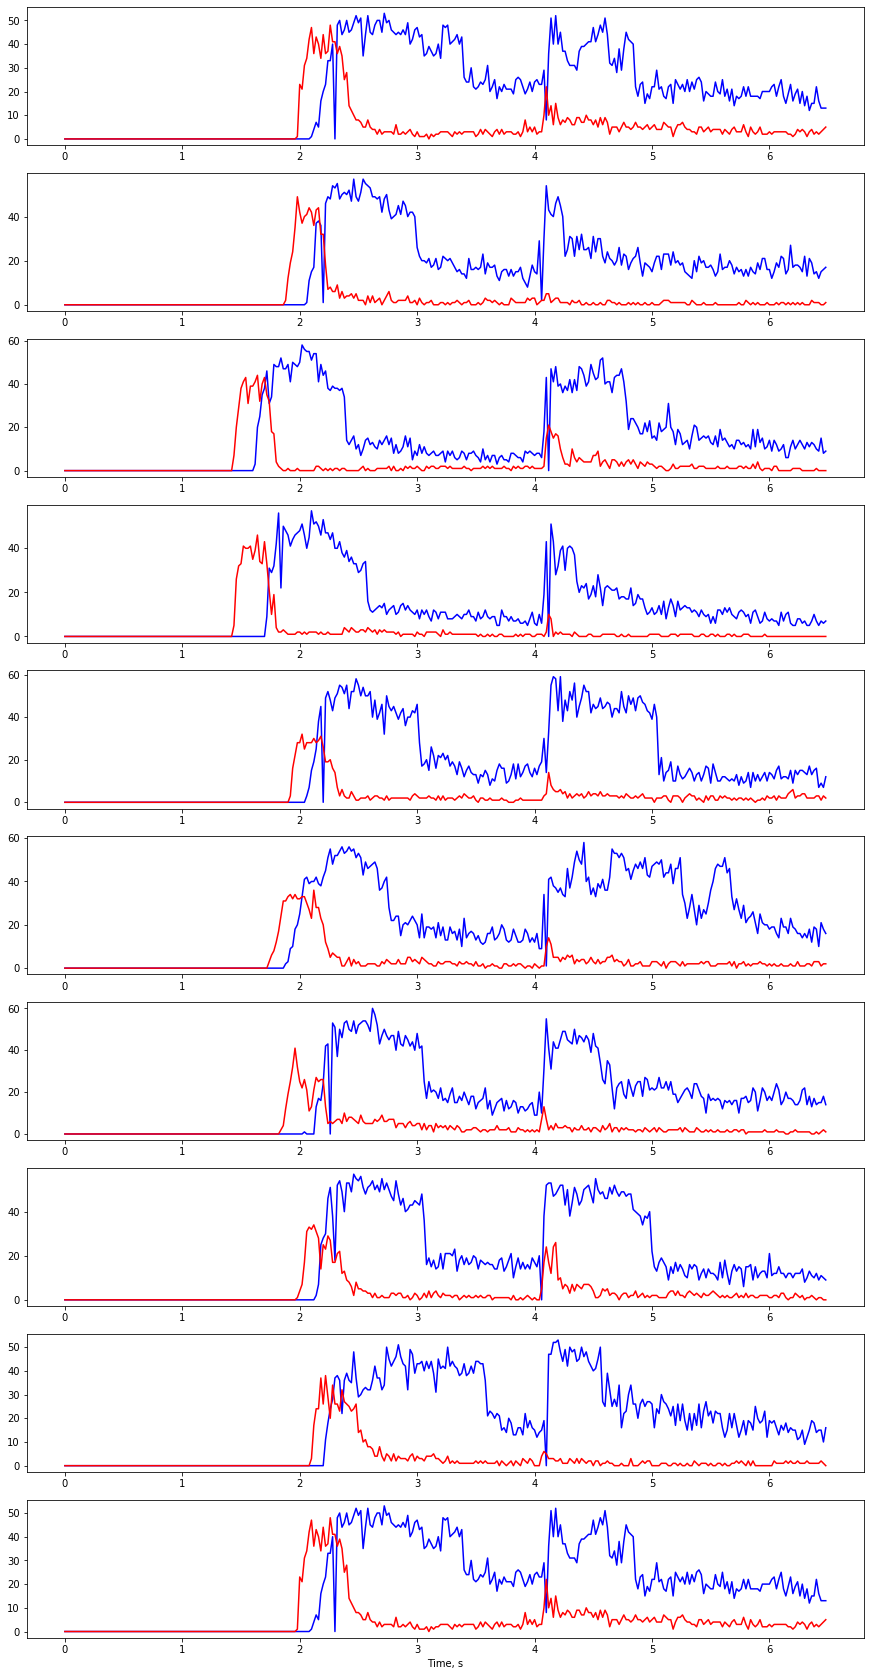

In [16]:
fig, ax = plt.subplots(10, figsize=(15,30))

count = 0
for i in np.random.randint(np.ones(10)*400):

    ax[count].plot(t, torch.sum( torch.sum( tact1, dim=1 ), dim=1 )[i], 'b')
    ax[count].plot(t, torch.sum( torch.sum( tact2_sub, dim=1 ), dim=1 )[i], 'r')
    ax[count]
    count+= 1
ax[count-1].set_xlabel('Time, s')

plt.show()
# y axes show number of spike counts

Some observations:

1. Red line (v2) is far more less spiky than blue line (v1).
2. Blue may carry more temporal patterns during different phase of robot actions.
3. v2 sensor is a ait fattier as it starts to spike earlier than v1.

## Section 2. Total Spike Count over datasets

In [17]:
import pickle
[tact_neg_spikes_v2, tact_pos_spikes_v2, tact_spikes_v2] = pickle.load(open('tact_spikes_count_v2.pk', 'rb'))

In [18]:
from scipy.signal import savgol_filter
def smooth(_x):
    return savgol_filter(_x, 81, 1)

[]

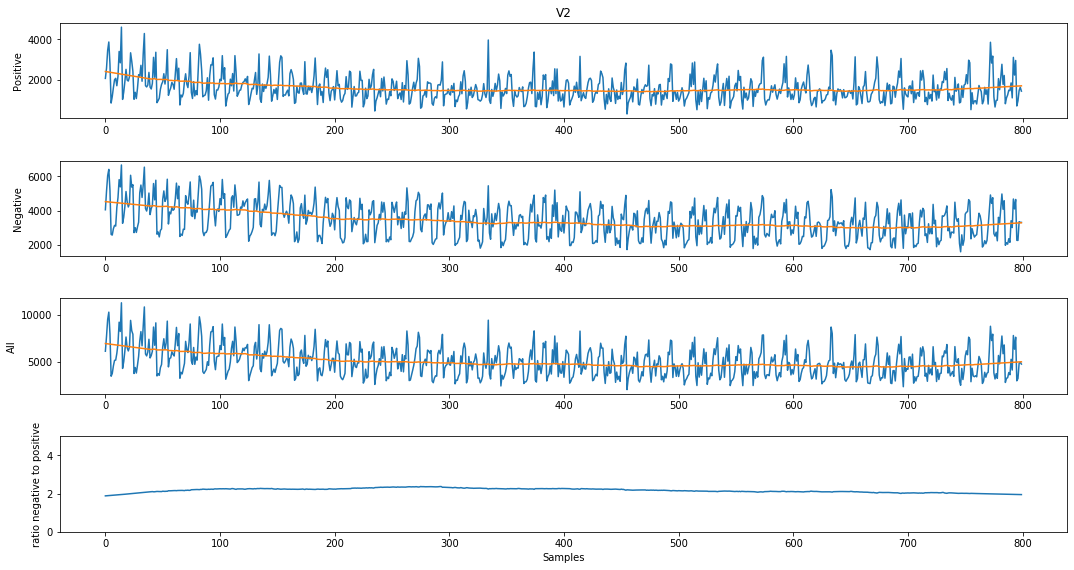

In [19]:
fig, ax = plt.subplots(4, figsize=(15,8))
ax[0].set_title('V2')
ax[0].plot(tact_pos_spikes_v2)
ax[0].plot( smooth(tact_pos_spikes_v2) )
ax[0].set_ylabel('Positive')

ax[1].plot(tact_neg_spikes_v2)
ax[1].plot( smooth(tact_neg_spikes_v2) )
ax[1].set_ylabel('Negative')

ax[2].plot(tact_spikes_v2)
ax[2].plot( smooth(tact_spikes_v2) )
ax[2].set_ylabel('All')

a = smooth(tact_neg_spikes_v2) / smooth(tact_pos_spikes_v2)

ax[3].plot( a )
ax[3].set_ylabel('ratio negative to positive')
ax[3].set_ylim([0,5])

ax[3].set_xlabel('Samples')
plt.tight_layout(True)
plt.plot()

We can see drift over time. It can be also ovserved by the size of the file for tactile data for v2.

In [20]:
import pickle
[tact_neg_spikes_v1, tact_pos_spikes_v1, tact_spikes_v1] = pickle.load(open('tact_spikes_count_v1.pk', 'rb'))

[]

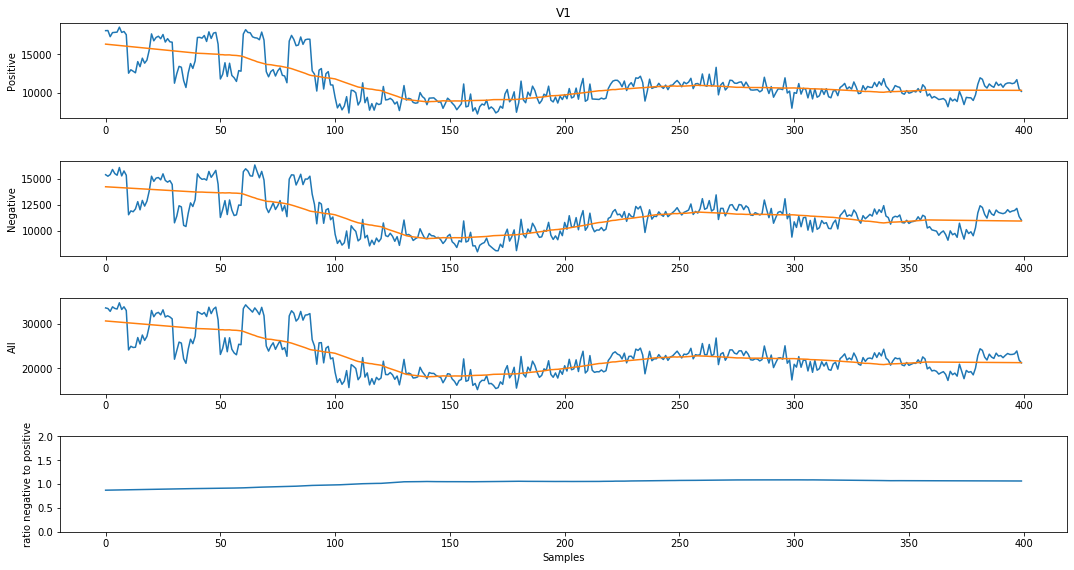

In [21]:
fig, ax = plt.subplots(4, figsize=(15,8))
ax[0].set_title('V1')
ax[0].plot(tact_pos_spikes_v1)
ax[0].plot( smooth(tact_pos_spikes_v1) )
ax[0].set_ylabel('Positive')

ax[1].plot(tact_neg_spikes_v1)
ax[1].plot( smooth(tact_neg_spikes_v1) )
ax[1].set_ylabel('Negative')

ax[2].plot(tact_spikes_v1)
ax[2].plot( smooth(tact_spikes_v1) )
ax[2].set_ylabel('All')

a = smooth(tact_neg_spikes_v1) / smooth(tact_pos_spikes_v1)

ax[3].plot( a )
ax[3].set_ylabel('ratio negative to positive')
ax[3].set_ylim([0,2])

ax[3].set_xlabel('Samples')
plt.tight_layout(True)
plt.plot()

V1 is not easiliy comparable with V2, as it's collected differently.

## Section 3. Learning classification using SNN on v2

We apply 2 layer MLP SNN model using SLAYER to our v2 data. Here I present the confusion matrix

<img src="confusion_matrix_by_blocks.png">

Y axis is predicted, X axis is actual class number. Here are some observations:

1. The objects are pretty seperable, but weight seperation is not clear.
2. Pepsi and Coffee is somehow misclassified.
3. In most of the diagonal blocks we can see that the heaviest division has one of the highest correct classification within that block.  This may indicate that our weight choices are too less sensitive to the v2 sensor.

## Section 4. V2 data visualization and clustering (for visualization only)

We apply tSne on tactile data, the distance is calculated using van Rossum distance. 

<img src="VR_all.png">

Observations:

1. Objects are seperated, weight divisions are not.
2. There are some overlab between coffee and pepsi, which is similar as given in confusion matrix.

Now, let's break down onto soy itself, since it's well seperated from the rest.

<img src="VR_soy.png">

In the above plot, we see no clear clustering or seperation within soy weight divisions. 

To be fair, we use another spike train similarity measure, Victor-Purpura distance, and it also yields similar result.

<img src="VP_all.png">

Now, let's cluster the weights by total number of spikes for soy only.

<img src="soy_weight.png">

Observations:

1. In "clustered by weights'' figure, we can see extremely weak patter of number of spikes increasing as the weight increases. More spikes are clearly seen in the heaviest soy division. But this pattern is really weak.

2. In the "collected order preserved'' figure, again, we see taht sensor drifts over time.